# Pattern Analysis
https://web.ist.utl.pt/rmch/dash/guides/AssociationRuleMining%20in%20Python.html

Association Pattern Analysis

- What are the aisles most purchased together?
- Which aisles are most reordered together?
- Which aisles are most ordered isolately?

ARM Resources
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook
- https://comum.rcaap.pt/bitstream/10400.26/37552/1/Tese_JoanaOliveira.pdf

# File and libraries

In [22]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [23]:
%run "scripts/dslabs_functions.py"

# data functions

In [42]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [ ]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # data=pd.read_csv(filepath)
    data=pd.read_csv(r'data\instacart_pre_proc_sample.csv')

    # Apply the sampling to each group 0.5%
    sample=0.5
    data = sample_user_orders(data, fraction=sample)


else:
    # data=pd.read_csv(r'data\instacart_pre_proc.csv')
    
    data=pd.read_csv(r'data\instacart_pre_proc_sample.csv')

    # Apply the sampling to each group 1%
    # sample=0.05
    # data = sample_user_orders(data, fraction=sample)



data=enrich_instacart_df(data)



data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296999 entries, 0 to 1296998
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   order_id                 1296999 non-null  int64  
 1   product_id               1296999 non-null  int64  
 2   add_to_cart_order        1296999 non-null  int64  
 3   reordered                1296999 non-null  int64  
 4   user_id                  1296999 non-null  int64  
 5   order_number             1296999 non-null  int64  
 6   order_dow                1296999 non-null  int64  
 7   order_hour_of_day        1296999 non-null  int64  
 8   days_since_prior_order   1214754 non-null  float64
 9   order_time_of_day        1296999 non-null  object 
 10  is_weekend               1296999 non-null  int64  
 11  is_peak_time_of_day      1296999 non-null  int64  
 12  weeks_since_prior_order  1214754 non-null  float64
 13  order_time_of_day_enc    1296999 non-null 

## drop nulls

- this will drop all first buying orders from the dataframe

In [26]:
# drop any null values
data=data.dropna()

# department correlation visualization

In [46]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


department_df = data.pivot_table(index='order_id', columns='department', values='product_id', aggfunc='count', fill_value=0)
# Convert the DataFrame to boolean type
department_df = department_df.astype(bool)


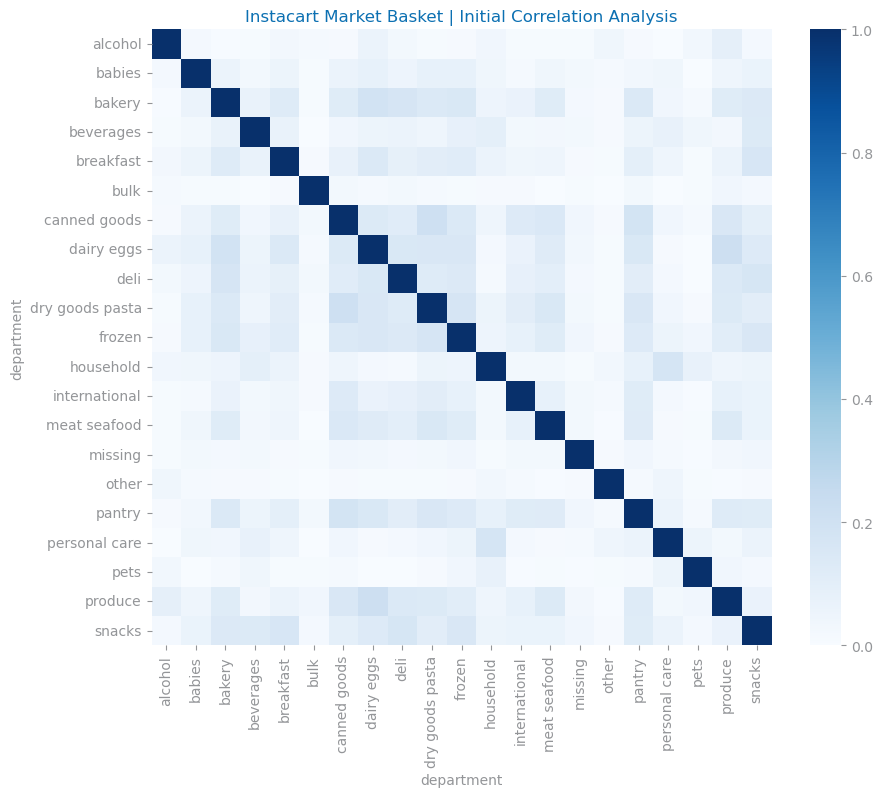

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_mtx = department_df.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=False, cmap="Blues", vmin=0, vmax=1)
plt.title(f'{file_tag} | Department Buying Correlation Analysis')
plt.savefig(f"images/{file_tag}_correlation_analysis.png")
plt.show()

In [49]:
find_patterns(department_df, mine_rules=True, min_patterns=10, min_length=2, max_pvalue=0.05, min_confidence=0.6, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Number of found patterns: 20


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
0,"(frozen, beverages, dairy eggs)",(snacks),0.094861,0.634037,1.462543,"(frozen, beverages, dairy eggs, snacks)",4,0.0
10,"(frozen, beverages, produce)",(snacks),0.095476,0.623907,1.439178,"(frozen, beverages, produce, snacks)",4,0.0
18,"(frozen, beverages, produce, dairy eggs)",(snacks),0.083331,0.646494,1.491278,"(frozen, beverages, dairy eggs, snacks, produce)",5,0.0
59,"(dry goods pasta, snacks)","(produce, dairy eggs)",0.080772,0.796575,1.439660,"(produce, dry goods pasta, dairy eggs, snacks)",4,0.0
85,"(frozen, produce, pantry)",(snacks),0.083929,0.617807,1.425106,"(frozen, produce, snacks, pantry)",4,0.0
97,"(frozen, dairy eggs, pantry)",(snacks),0.082359,0.628144,1.448951,"(frozen, dairy eggs, snacks, pantry)",4,0.0
112,"(beverages, produce, pantry)",(snacks),0.086662,0.612063,1.411856,"(beverages, produce, snacks, pantry)",4,0.0
118,"(beverages, dairy eggs, pantry)",(snacks),0.085731,0.623565,1.438388,"(beverages, dairy eggs, snacks, pantry)",4,0.0
132,"(deli, pantry)","(produce, dairy eggs)",0.082342,0.787417,1.423107,"(produce, dairy eggs, deli, pantry)",4,0.0
144,"(frozen, deli)","(produce, dairy eggs)",0.090849,0.778806,1.407546,"(frozen, produce, dairy eggs, deli)",4,0.0


# aisle Order ID Mining
- group order ids and dummify aisle

In [27]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


aisle_df = data.pivot_table(index='order_id', columns='aisle', values='product_id', aggfunc='count', fill_value=0)
# Convert the DataFrame to boolean type
aisle_df = aisle_df.astype(bool)


## Top Aisles Association Pattern Mining

In [ ]:
find_patterns(aisle_df, mine_rules=True, min_patterns=10, min_length=2, max_pvalue=0.1, min_confidence=0.6, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Number of found patterns: 12


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
3,"(fresh fruits, packaged vegetables fruits)",(fresh vegetables),0.187089,0.692379,1.561513,"(fresh vegetables, fresh fruits, packaged vege...",3,0.0
4,"(fresh vegetables, packaged vegetables fruits)",(fresh fruits),0.187089,0.797175,1.427797,"(fresh vegetables, fresh fruits, packaged vege...",3,0.0
11,"(fresh fruits, packaged cheese)",(fresh vegetables),0.104672,0.677128,1.527119,"(fresh vegetables, fresh fruits, packaged cheese)",3,0.0
16,"(packaged vegetables fruits, packaged cheese)",(fresh fruits),0.089578,0.791936,1.418412,"(fresh fruits, packaged vegetables fruits, pac...",3,0.0
22,"(packaged vegetables fruits, packaged cheese)",(fresh vegetables),0.080772,0.714086,1.610470,"(fresh vegetables, packaged vegetables fruits,...",3,0.0
28,"(yogurt, packaged vegetables fruits)",(fresh fruits),0.105195,0.823663,1.475238,"(fresh fruits, yogurt, packaged vegetables fru...",3,0.0
32,"(fresh vegetables, yogurt)",(packaged vegetables fruits),0.087825,0.609407,1.658221,"(fresh vegetables, yogurt, packaged vegetables...",3,0.0
34,"(yogurt, packaged vegetables fruits)",(fresh vegetables),0.087825,0.687654,1.550859,"(fresh vegetables, yogurt, packaged vegetables...",3,0.0
38,"(fresh vegetables, yogurt)",(fresh fruits),0.117432,0.814849,1.459451,"(fresh vegetables, yogurt, fresh fruits)",3,0.0
40,"(yogurt, fresh fruits)",(fresh vegetables),0.117432,0.623445,1.406049,"(fresh vegetables, yogurt, fresh fruits)",3,0.0


In [30]:
find_patterns(aisle_df,mine_rules = False, min_patterns = 5, min_length = 3, max_pvalue = 0.2)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Number of found patterns: 5


,support,itemsets,length,significance
19,0.187089,"(fresh fruits, fresh vegetables, packaged vege...",3,0.0
23,0.104672,"(fresh vegetables, fresh fruits, packaged cheese)",3,0.0
30,0.105195,"(fresh fruits, yogurt, packaged vegetables fru...",3,0.0
31,0.117432,"(fresh vegetables, yogurt, fresh fruits)",3,0.0
35,0.100128,"(fresh vegetables, milk, fresh fruits)",3,0.0


# Top Products Orders Mining

## Dataset Prep

In [31]:
# Group by order_id and aggregate features
multi_product_order_agg = data.groupby('order_id').agg({
    'add_to_cart_order': 'max',
}).rename(columns={'add_to_cart_order': 'num_products'})

# Filter to orders where num_products > 1
multi_product_order_agg = multi_product_order_agg[multi_product_order_agg['num_products'] > 1]

# Merge with orders data
data_multi = data.merge(multi_product_order_agg, on='order_id', how='inner')
# Group by product_name and get the top 300 products purchased (count of unique order ids)
top_products = data_multi.groupby('product_name')['order_id'].nunique().nlargest(1000).index.tolist()

# Filter the dataframe to include only the top 300 products
data_multi = data_multi[data_multi['product_name'].isin(top_products)]

In [32]:
product_crosstab = data_multi.pivot_table(index='order_id', columns='product_name', values='product_id', aggfunc='count', fill_value=0)
# product_crosstab = (product_crosstab > 0).astype(int)
# product_crosstab
product_crosstab = product_crosstab.astype(bool)


## top products association pattern mining

In [33]:
# # Generate frequent itemsets using fpgrowth
# frequent_products = fpgrowth(product_crosstab, min_support=0.01, use_colnames=True)

# # Generate association rules
# rules_product = association_rules(frequent_products, metric="lift", min_threshold=1.0)

# # Display the main metrics
# rules_product[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']]
# rules_product

In [ ]:
find_patterns(product_crosstab, mine_rules=True, min_patterns=10, min_length=3, max_pvalue=0.1, min_confidence=0.6, min_lift=1.4)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Finding patterns with min sup 0.071790
Finding patterns with min

,antecedents,consequents,support,confidence,lift,itemsets,length,significance
54,"(Large Lemon, Organic Baby Spinach)",(Banana),0.006,0.750000,4.310345,"(Large Lemon, Organic Baby Spinach, Banana)",3,9.425096e-05
68,"(Strawberries, Large Lemon)",(Banana),0.004,0.666667,3.831418,"(Strawberries, Large Lemon, Banana)",3,5.430952e-04
90,"(Banana, Marinara Pasta Sauce)",(Organic Baby Spinach),0.004,1.000000,9.345794,"(Banana, Marinara Pasta Sauce, Organic Baby Sp...",3,5.901077e-06
92,"(Marinara Pasta Sauce, Organic Baby Spinach)",(Banana),0.004,1.000000,5.747126,"(Banana, Marinara Pasta Sauce, Organic Baby Sp...",3,5.901077e-06
94,(Marinara Pasta Sauce),"(Banana, Organic Baby Spinach)",0.004,0.666667,30.303030,"(Banana, Marinara Pasta Sauce, Organic Baby Sp...",3,5.901077e-06
111,"(Organic Lemon, Organic Baby Spinach)",(Bag of Organic Bananas),0.004,0.800000,7.272727,"(Organic Lemon, Organic Baby Spinach, Bag of O...",3,5.498355e-04
179,"(Organic Baby Arugula, Organic Red Onion)",(Organic Baby Spinach),0.004,1.000000,9.345794,"(Organic Baby Arugula, Organic Baby Spinach, O...",3,8.843083e-08
180,"(Organic Baby Spinach, Organic Red Onion)",(Organic Baby Arugula),0.004,0.666667,27.777778,"(Organic Baby Arugula, Organic Baby Spinach, O...",3,8.843083e-08
208,"(Organic Strawberries, Organic Avocado)",(Bag of Organic Bananas),0.005,0.714286,6.493506,"(Organic Strawberries, Bag of Organic Bananas,...",3,3.045487e-04
320,"(Organic Zucchini, Organic Strawberries)",(Bag of Organic Bananas),0.004,0.666667,6.060606,"(Bag of Organic Bananas, Organic Zucchini, Org...",3,2.735974e-04


In [44]:
find_patterns(product_crosstab,mine_rules = False, min_patterns = 5, min_length = 3, max_pvalue = 0.2)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419
Finding patterns with min sup 0.098477
Finding patterns with min sup 0.088629
Finding patterns with min sup 0.079766
Finding patterns with min sup 0.071790
Finding patterns with min

,support,itemsets,length,significance
417,0.006,"(Large Lemon, Organic Baby Spinach, Banana)",3,0.000094
446,0.005,"(Bag of Organic Bananas, Organic Avocado, Orga...",3,0.000305
469,0.005,"(Organic Hass Avocado, Bag of Organic Bananas,...",3,0.003827
470,0.006,"(Bag of Organic Bananas, Organic Hass Avocado,...",3,0.000199
495,0.005,"(Bag of Organic Bananas, Organic Hass Avocado,...",3,0.000073
523,0.006,"(Bag of Organic Bananas, Organic Baby Spinach,...",3,0.000626
543,0.005,"(Apple Honeycrisp Organic, Bag of Organic Bana...",3,0.000019
